# Playing Black Jack
We want to train a network that plays black jack.

We are using the [Gymnasium black jack](https://gymnasium.farama.org/environments/toy_text/blackjack/) library as game.

## Actions
The agent will have 2 options, hit (take another card) or stick (stop taking cards)

## Environment (observation space)
The environment consists of a 3-tuple containing: the player’s current sum, the value of the dealer’s one showing card (1-10 where 1 is ace), and whether the player holds a usable ace (0 or 1).

The observation is returned as (int(), int(), int()).


## Rewards
- +1 point for winning
- -1 point for loosing
- 0 points for draw

In [1]:
import numpy as np
import random
from IPython import display
from IPython.display import clear_output
from collections import deque

import gymnasium as gym

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [2]:
env = gym.make("Blackjack-v1", render_mode="rgb_array")
action_size = env.action_space.n
state_size = 3

print('Number of actions: {}'.format(action_size))

Number of actions: 2


# Playing the game with random actions

Player hand: [9, 4], 13
Reward: -1.0
Dealer hand: [7, 10], 17


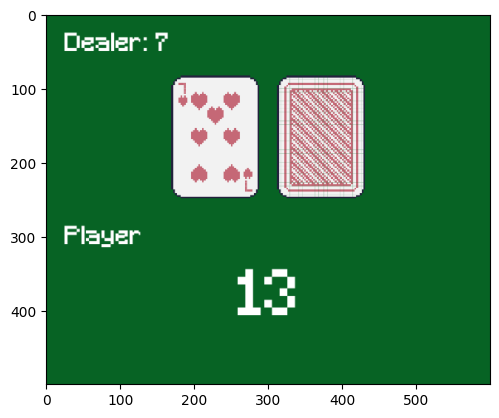

In [3]:
env.reset()
for i in range(10):
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _, _ = env.step(env.action_space.sample()) # take a random action
    if done:
        plt.imshow(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        print(f'Player hand: {env.unwrapped.player}, {sum(env.unwrapped.player)}')
        print(f'Reward: {reward}')
        print(f'Dealer hand: {env.unwrapped.dealer}, {sum(env.unwrapped.dealer)}')
        break

## Crate agent

In [4]:
# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=200)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0]))
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
agent = DQNAgent(state_size, action_size)

c:\KODA\ITHS\9_DeepLearning\DeepLearning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Player hand: [9, 1], 10
Reward: -1.0
Dealer hand: [1, 10], 11


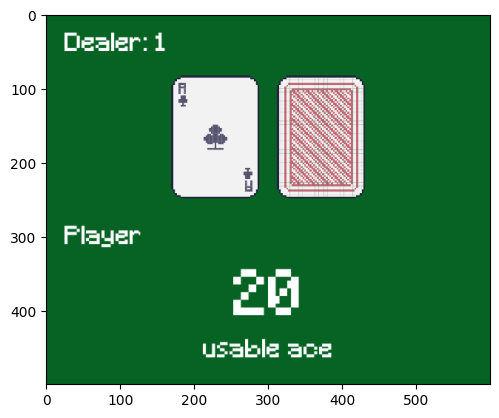

In [6]:
state = env.reset()[0]
state = np.reshape(state, [1, state_size])
for i in range(10):
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _, _ = env.step(agent.act(state))
    if done:
        plt.imshow(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        print(f'Player hand: {env.unwrapped.player}, {sum(env.unwrapped.player)}')
        print(f'Reward: {reward}')
        print(f'Dealer hand: {env.unwrapped.dealer}, {sum(env.unwrapped.dealer)}')
        break

# Train agent

In [7]:
# Training the Agent
episodes = 50
batch_size = 16

In [8]:
for e in range(episodes):
    state = env.reset()[0]
    state = np.reshape(state, [1, state_size])
    
    for time in range(10):  # Maximum number of steps
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("Episode: {}/{}, Score: {}, Epsilon: {:.2f}".format(e, episodes, reward, agent.epsilon))
        if done and (e % 20 == 0):
            print("Episode: {}/{}, Score: {}, Epsilon: {:.2f}".format(e, episodes, reward, agent.epsilon))
            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

Episode: 0/50, Score: -1.0, Epsilon: 1.00
Episode: 0/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 1/50, Score: -1.0, Epsilon: 1.00
Episode: 2/50, Score: -1.0, Epsilon: 1.00
Episode: 2/50, Score: -1.0, Epsilon: 1.00
Episode: 2/50, Score: -1.0, Epsilon: 1.00
Episode: 2/50, Score: -1.0, Epsilon: 1.00
Episode: 2/50, Score: -1.0, Epsilon: 1.00
Episode: 2/50, Score: -1.0, Epsilon: 0.99
Episode: 2/50, Score: -1.0, Epsilon: 0.99
Episode: 2/50, Score: -1.0, Epsilon: 0.99
Episode: 2/50, Score: -1.0, Epsilon: 0.98
Episode: 3/50, Score: -1.0, Epsilon: 0.97
Episode: 3/50, Score: -1.0, Epsilon: 0.97
Episode: 3/50, Score: -1.0, Epsilon: 0.96
Episode: 3/50, Score: -1.0, Epsilo

KeyboardInterrupt: 

# Play the game with the agent

Player hand: [7, 10], 17
Reward: 0.0
Dealer hand: [10, 3, 4], 17


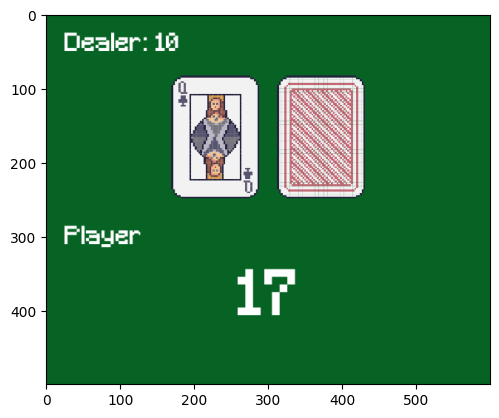

In [ ]:
state = env.reset()[0]
state = np.reshape(state, [1, state_size])
for i in range(10):
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _, _ = env.step(agent.act(state))
    if done:
        plt.imshow(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        print(f'Player hand: {env.unwrapped.player}, {sum(env.unwrapped.player)}')
        print(f'Reward: {reward}')
        print(f'Dealer hand: {env.unwrapped.dealer}, {sum(env.unwrapped.dealer)}')
        break

# Tasks
Experiment with the agent structure.
- Layers
- Activation functions
- Epsilon
- Gamma
- Memory
- Batch size

Evaluate how many games the agent wins over time (For example 100+ games). How does it compare to just doing random actions?